# Investigation of the targets

The TReNDS dataset came with 5 different targets:
- Age
- Domain1: Var1 and Var2
- Domain2: Var1 and Var2

The assumption is that the Var1 and Var2 in the wo domains are somehow related to each other. Either through type of measurement or something else.

So, before digging too much into feature engineering and modeling, I first investigated the target features.

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

## 1. Take a first look at the targets

In [3]:
# Load the target features
targets = pd.read_csv('/kaggle/input/trends-assessment-prediction/train_scores.csv').set_index('Id')
targets.head()

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
Id,,,,,
10001,57.436077,30.571975,62.553736,53.325130,51.427998
10002,59.580851,50.969456,67.470628,60.651856,58.311361
10004,71.413018,53.152498,58.012103,52.418389,62.536641
10005,66.532630,NaN,NaN,52.108977,69.993075
10007,38.617381,49.197021,65.674285,40.151376,34.096421


age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

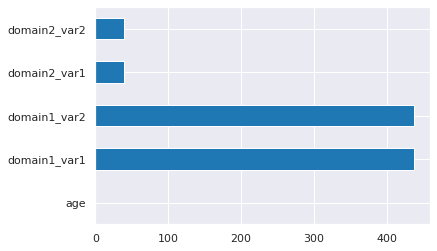

In [4]:
# How many null values does each target have
n_nulls = targets.isnull().sum()
display(n_nulls)
n_nulls.plot.barh();

### Observation 1

So the first hunch is correct. Domain 1 and domain 2 seem to be connected, as they both contain the same amount of missing values.

Before we do any more explorations, let's get rid of these missing values.

In [5]:
targets.dropna(inplace=True)

But how much are they connected? Let's look at a correlation plot:

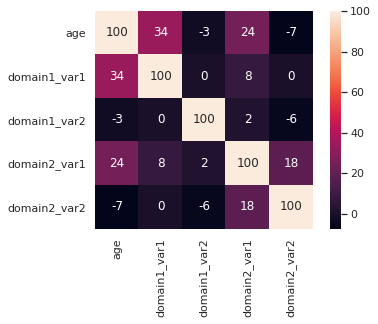

In [6]:
sns.heatmap(targets.corr()*100, square=True, annot=True, fmt='.0f');

### Observation 2

Interesting, while there is a slight correlation within domain 2, there doesn't seem to be one within domain 1. So, the targets were measured in the same domain, but do not necessarily encode a connected property. Except for this domain2 connection... We will see more why.

Also, why do both var2 have a correlation with age? Haven't figured this one out yet.

## Let's visualize the targets

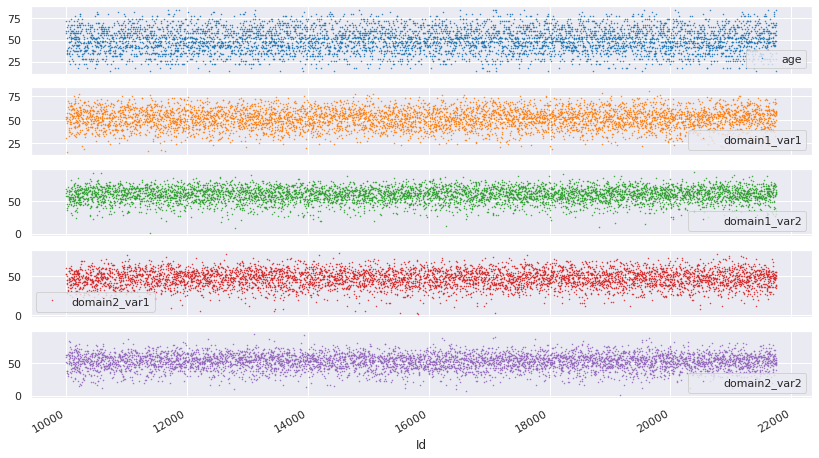

In [7]:
targets.plot(lw=0, marker='.', markersize=1, subplots=True, figsize=(14, 8));

Just looking at the targets, most seems to be normal. Except for age, something is off here... Let's have a closer look.

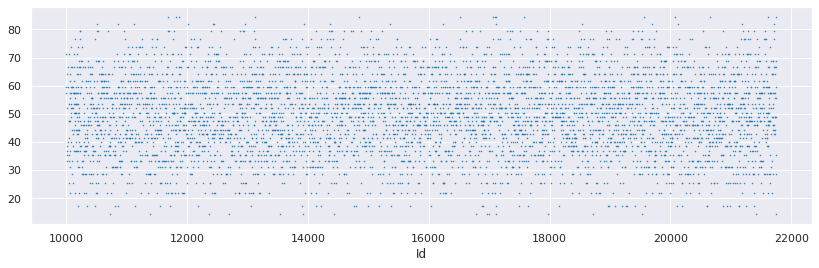

In [8]:
targets['age'].plot(lw=0, marker='.', markersize=1, figsize=(14, 4));

### Observation 3

Age seems to be discrete. Let's take a look at the unique values. How many unique values does this target contain?

In [9]:
targets['age'].nunique()

33

And how are they distributed over the target?

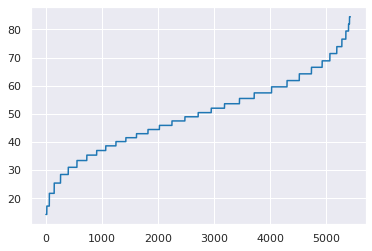

In [10]:
plt.plot(targets['age'].sort_values().values);

### Decision 1

Interesting! So, if we try to predict this feature, it might be worth it to restrict the predictions to these 33 unique values.

### Visualize target relationships

Let's use a simple pairplot to see how the features vary together.

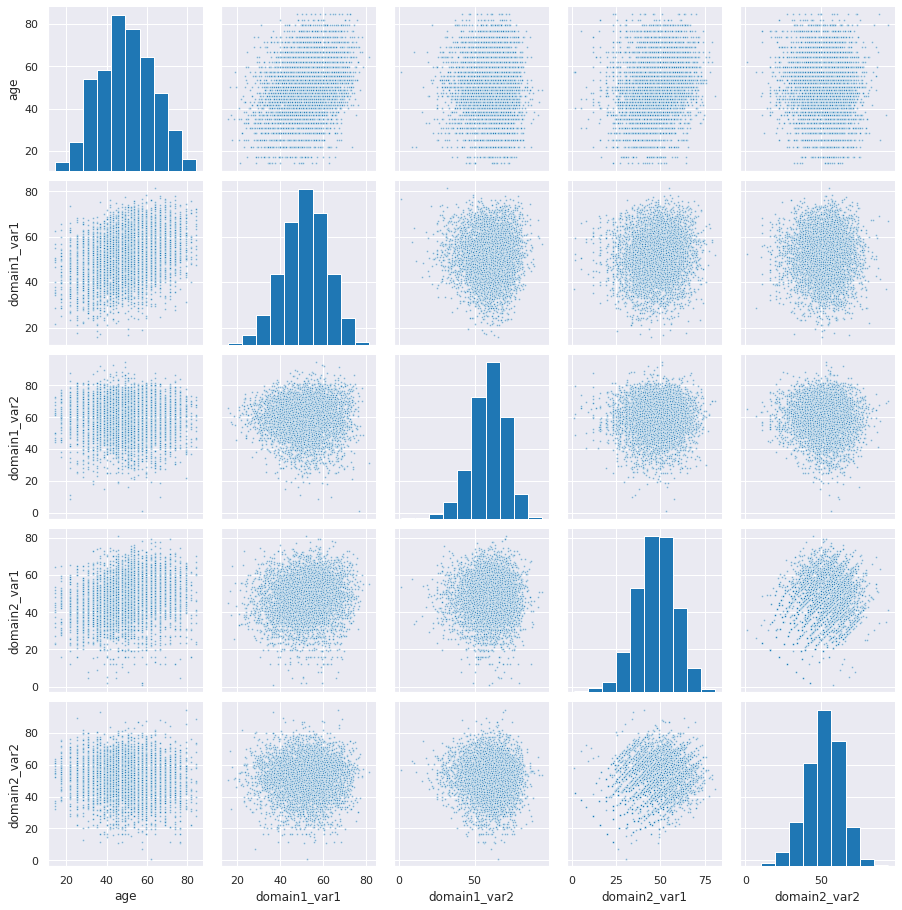

In [11]:
sns.pairplot(targets, plot_kws=dict(s=5, alpha=0.5));

### Observation 4

We can see again the stratification of age, but what is more interesting is the relationship within domain2. What's happening there?

## Investigation of domain2

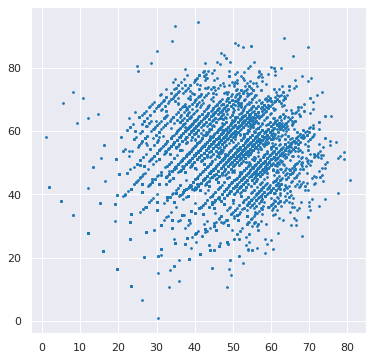

In [12]:
plt.figure(figsize=(6, 6))
d2 = targets.dropna().iloc[:, 3:].values
plt.scatter(d2[:, 0], d2[:, 1], s=3);

Yes, something is definitely off. What about this strange line on the left? Also, is there some stratification happening here as well?

Let's digg deeper. What about rotating these two features?

In [13]:
def rotate_origin(x, y, radians):
    """Rotates a point around the origin (0, 0)."""
    xx = x * np.cos(radians) + y * np.sin(radians)
    yy = -x * np.sin(radians) + y * np.cos(radians)
    return np.array([xx, yy]).T

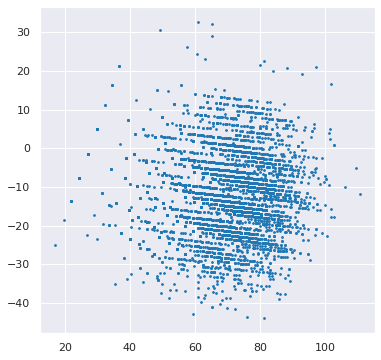

In [14]:
# Let's rotate the domain 2 variables by 1 radian
d2_rot = rotate_origin(d2[:, 0], d2[:, 1], 1)
plt.figure(figsize=(6, 6))
plt.scatter(d2_rot[:, 0], d2_rot[:, 1], s=3);

It seems that does something, but how to best figure out what the best rotation is?

Hmm... it seems there are some lines in the data with respect to var2. So, let's rotate different values and see if we can find these lines.

The idea, rotate the points and check for the number of unique values with respect to var2. The implemetation is very sensitive to the right target region:

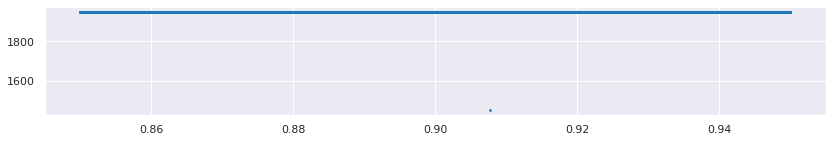

In [15]:
# Let's explore between 0.85 and 0.95 radians
n_uniques = []
for r in np.linspace(0.85, 0.95, 5000):
    d22_rot = rotate_origin(d2[:, 0], d2[:, 1], r)[:, 1]
    n_uniques.append([r, len(np.unique(np.round(d22_rot, 6)))])
n_uniques = np.array(n_uniques)

plt.figure(figsize=(14, 2))
plt.scatter(n_uniques[:, 0], n_uniques[:, 1], s=3);

There is something there. Let's enhance!

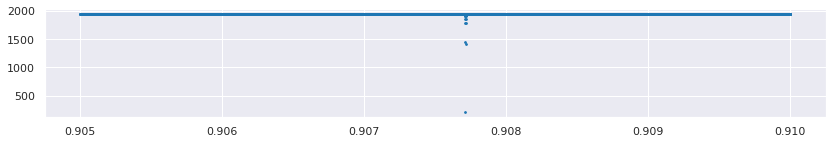

In [16]:
# Let's explore between 0.905 and 0.910 radians
n_uniques = []
for r in np.linspace(0.905, 0.910, 5000):
    d22_rot = rotate_origin(d2[:, 0], d2[:, 1], r)[:, 1]
    n_uniques.append([r, len(np.unique(np.round(d22_rot, 6)))])
n_uniques = np.array(n_uniques)

plt.figure(figsize=(14, 2))
plt.scatter(n_uniques[:, 0], n_uniques[:, 1], s=3);

And repeat, and repeat and repeat...

In [17]:
d2_rot

array([[ 72.08685859, -17.08488428],
       [ 81.83765568, -19.53101438],
       [ 80.9445456 , -10.31986168],
       ...,
       [ 63.51063939,  -5.11283308],
       [ 69.40417975, -21.34243893],
       [ 69.36915898, -14.78627177]])

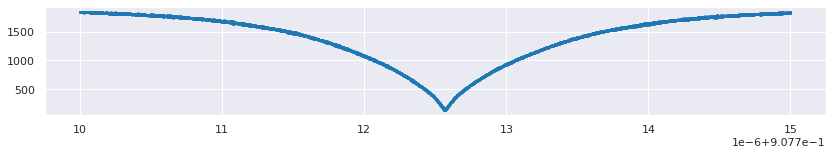

In [18]:
# Let's explore between 0.90771 and 0.907715 radians
n_uniques = []
for r in np.linspace(0.90771, 0.907715, 5000):
    d22_rot = rotate_origin(d2[:, 0], d2[:, 1], r)[:, 1]
    n_uniques.append([r, len(np.unique(np.round(d22_rot, 6)))])
n_uniques = np.array(n_uniques)

plt.figure(figsize=(14, 2))
plt.scatter(n_uniques[:, 0], n_uniques[:, 1], s=3);

After a long search, we find that `radians=0.90771256655` does the trick.

In [19]:
rot = 0.90771256655

d22_rot = rotate_origin(d2[:, 0], d2[:, 1], rot)[:, 1]
n_unique_entries = len(np.unique(np.round(d22_rot, 6)))

print('Optimal rotation leads to %d unique entries on domain2_var2' % n_unique_entries)

Optimal rotation leads to 125 unique entries on domain2_var2


And what does this look like?

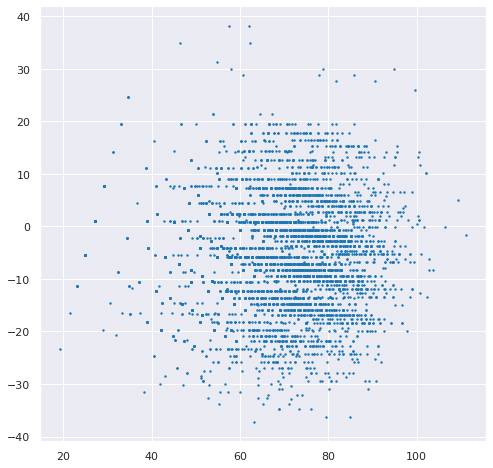

In [20]:
# Let's rotate the domain 2 variables by 1 radian
d2_rot = rotate_origin(d2[:, 0], d2[:, 1], rot)
plt.figure(figsize=(8, 8))
plt.scatter(d2_rot[:, 0], d2_rot[:, 1], s=2);

### Observation 5

There seems to be a "perfect" rotation for domain2. I've tried to further investigate this (e.g. the "outliers" on the left or on the top" or finding the offset to "align the features with respect to var 2. But this never worked, as it seems to have some internal overlap of grading systems.

We can see this once we some in a bit.

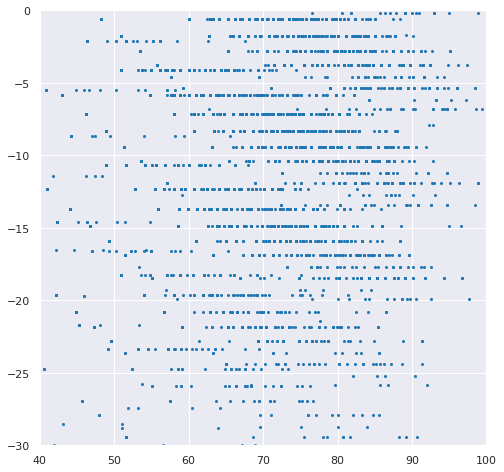

In [21]:
# Let's rotate the domain 2 variables by 1 radian
d2_rot = rotate_origin(d2[:, 0], d2[:, 1], rot)
plt.figure(figsize=(8, 8))
plt.scatter(d2_rot[:, 0], d2_rot[:, 1], s=4)
plt.xlim(40, 100)
plt.ylim(-30, 0);

So, let's add these rotated features to the other five targets. And plot the correlation matrix once more.

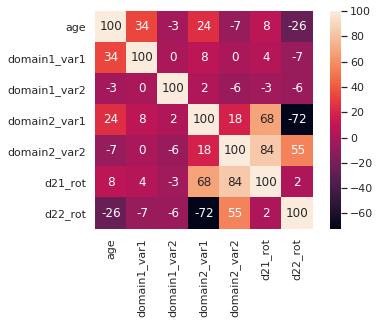

In [22]:
targets.loc[:, 'd21_rot'] = d2_rot[:, 0]
targets.loc[:, 'd22_rot'] = d2_rot[:, 1]

sns.heatmap(targets.corr()*100, square=True, annot=True, fmt='.0f');

While this is super interesting, I unfortunately was never able to truely profit from this insight. As the prediction of these rotated features need to be super exact so that the inverse rotation leads to useful target values. I've tried some NeuralNets with multi loss functions to predict domain2 targets with and without rotation, but wasn't able to make it work. But more about this in another post.

For the curious ones, here's also the "step" plot for domain2_var2 after rotation.

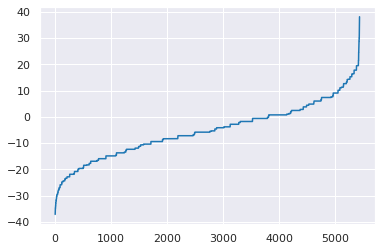

In [23]:
plt.plot(targets['d22_rot'].sort_values().values);

## What about the value distributions in general?

A target is often best predicted if it follows a gaussian distribution, so let's take a look at the distributions.

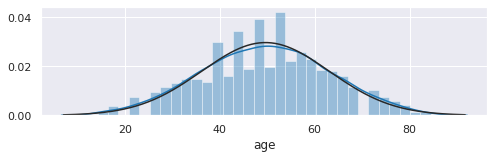

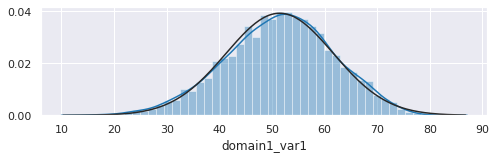

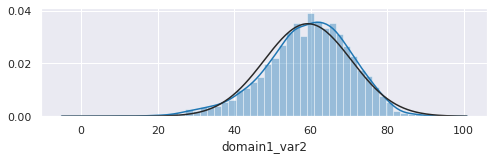

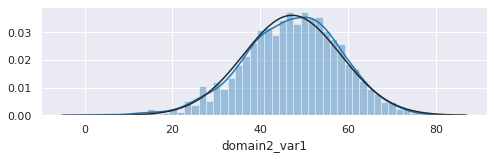

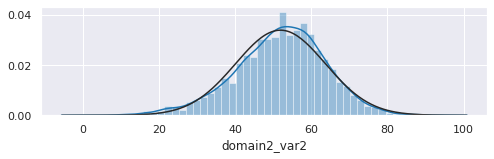

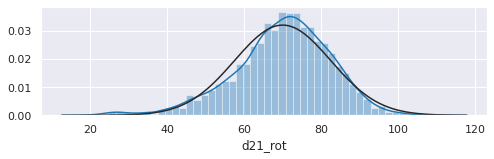

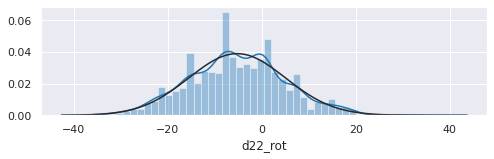

In [24]:
from scipy.stats import norm
for col in targets.columns:
    plt.figure(figsize=(8, 2))
    sns.distplot(targets[col], fit=norm, kde=True)
    plt.show()

### Observation 6

Age seems to be normal distributed, while the others might profit from a transformation. Using a similiar iterative approach as for finding the optimal rotation, I tried to find the optimal power transformation for all features:

In [25]:
pow_age = 0.93
pow_d1v1 = 1.25
pow_d1v2 = 1.72
pow_d2v1 = 1.37
pow_d2v2 = 1.39
pow_d21 = 1.85
pow_d22 = 1

powers = [pow_age, pow_d1v1, pow_d1v2, pow_d2v1, pow_d2v2, pow_d21, pow_d22 ]

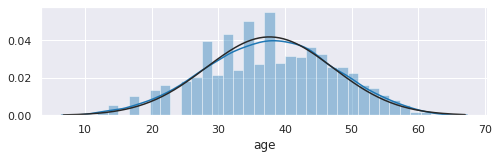

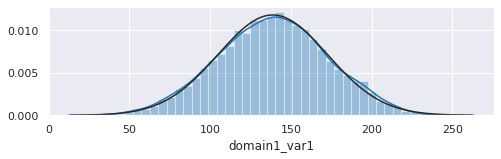

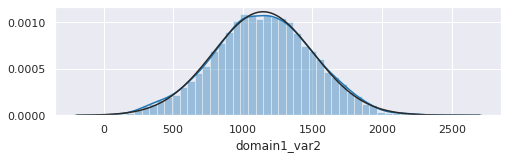

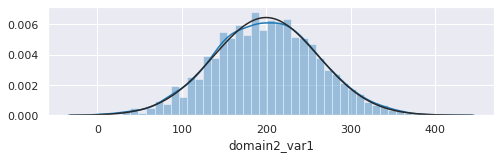

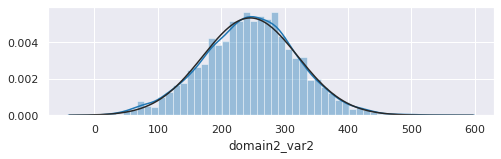

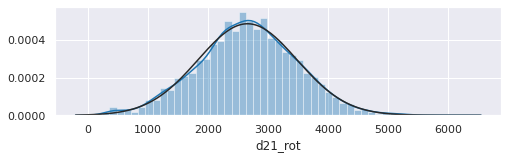

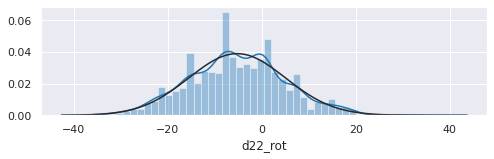

In [26]:
from scipy.stats import norm
for i, col in enumerate(targets.columns):
    plt.figure(figsize=(8, 2))
    sns.distplot(np.power(targets[col], powers[i]), fit=norm, kde=True)
    plt.show()

While this looks all great and nice, this approach turned out to lead to worse results (probably due to overfitting). What I've ended up with is a simple transformation of 1.5 for target 1 to 4:

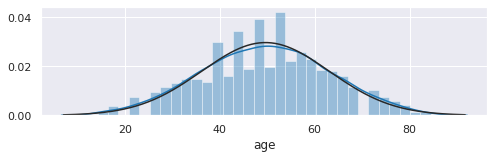

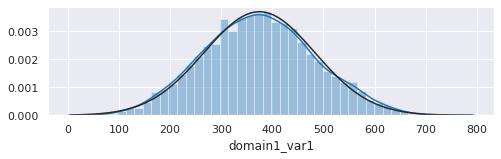

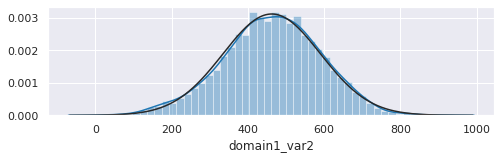

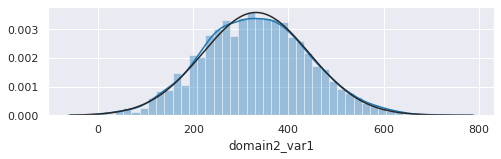

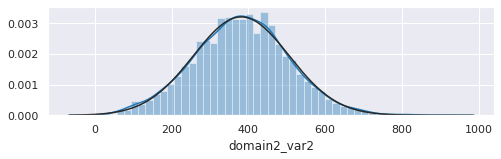

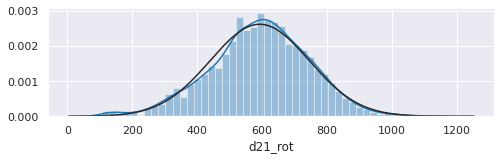

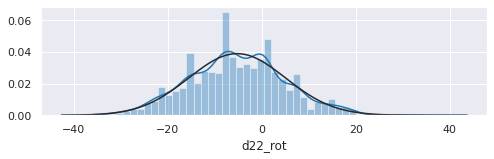

In [27]:
pow_age = 1.0
pow_d1v1 = 1.5
pow_d1v2 = 1.5
pow_d2v1 = 1.5
pow_d2v2 = 1.5
pow_d21 = 1.5
pow_d22 = 1

powers = [pow_age, pow_d1v1, pow_d1v2, pow_d2v1, pow_d2v2, pow_d21, pow_d22 ]

from scipy.stats import norm
for i, col in enumerate(targets.columns):
    plt.figure(figsize=(8, 2))
    sns.distplot(np.power(targets[col], powers[i]), fit=norm, kde=True)
    plt.show()

### Decision 2

The 5 target features were transformed with a power of 1, 1.5, 1.5, 1.5, 1.5.

### Decision 3

At the very end, these targets were also scaled using a standard scaler.